# Forecast Bike Rentals

**Goal** 

<ul>
<li>Forecast(predict) bike rental demand (number of bike users (‘cnt’)) on hourly basis.</li>
</ul>

**How**

<ul>
<li>Machine Learning with historical usage patterns and weather data.</li>
</ul>


**Dataset summary** 

1. instant: record index

2. dteday : date

3. season: season (1: springer, 2: summer, 3: fall, 4: winter)

4. yr: year (0: 2011, 1:2012)

5. mnth: month (1 to 12)

6. hr: hour (0 to 23)

7. holiday: whether the day is a holiday or not

8. weekday: day of the week

9. workingday: if day is neither weekend nor holiday is 1, otherwise is 0.

10. weathersit (1:, 2:, 3:, 4:)

11. temp: Normalized temperature in Celsius. The values are derived via `(tt_min)/(t_maxt_min), t_min=*8, t_max=+39` (only in hourly scale)
    
12. atemp: Normalized feeling temperature in Celsius. The values are derived via `(tt_min)/(t_maxt_min), t_min=*16, t_max=+50` (only in hourly scale)

13. hum: Normalized humidity. The values are divided to 100 (max)

14. windspeed: Normalized wind speed. The values are divided to 67 (max)

15. casual: count of casual users

16. registered: count of registered users

17. cnt: count of total rental bikes including both casual and registered users

In [15]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import os

import seaborn as sns

import xgboost
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



print("Libraries Imported")


Libraries Imported


**Importing data**

Import bike dataset:

In [2]:
df_bike = pd.read_csv("data/hour.csv")
df_bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df_bike.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [4]:
df_bike['weathersit'].unique()

array([1, 2, 3, 4], dtype=int64)

Categories of weathersit variable:

1. Clear, Few clouds, Partly cloudy, Partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

Checking missing values:

In [5]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Checking statistical distribution:

In [6]:
df_bike.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


**Cleaning Data**

Selecting columns and dropping them:

In [7]:
columnsToDrop = df_bike[['instant','casual','registered','atemp','dteday']]
columnsToDrop.head()

,instant,casual,registered,atemp,dteday
0,1,3,13,0.2879,2011-01-01
1,2,8,32,0.2727,2011-01-01
2,3,5,27,0.2727,2011-01-01
3,4,3,10,0.2879,2011-01-01
4,5,0,1,0.2879,2011-01-01


In [8]:
df_bike.drop(['instant','casual','registered','atemp','dteday'], axis=1, inplace = True)

In [9]:
df_bike['dayCount'] = pd.Series(range(df_bike.shape[0]))/24
df_bike.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,dayCount
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16,0.000000
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40,0.041667
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32,0.083333
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13,0.125000
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,0.166667


Correlation visualization:

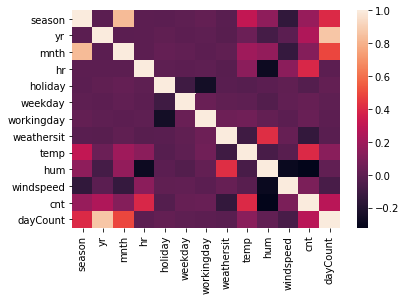

In [16]:
sns.heatmap(df_bike.corr())


**Splitting train and test sets**

In [10]:
train_set, test_set = train_test_split(df_bike, test_size=0.3, random_state=42)

print('Train set has', len(train_set), 'samples')
print('Test set has', len(test_set), 'samples')

train_set.sort_values('dayCount', axis= 0, inplace=True)
test_set.sort_values('dayCount', axis= 0, inplace=True)

Train set has 12165 samples
Test set has 5214 samples


<ipython-input-10-50282145d5f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.sort_values('dayCount', axis= 0, inplace=True)
<ipython-input-10-50282145d5f2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.sort_values('dayCount', axis= 0, inplace=True)


Writing function to show scores:

In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

**Feature Scaling the Dataset**

In [12]:
columnsToScale = ['temp','hum','windspeed']

scaler = StandardScaler()

train_set[columnsToScale] = scaler.fit_transform(train_set[columnsToScale])
test_set[columnsToScale] = scaler.transform(test_set[columnsToScale])
train_set[columnsToScale].describe()

<ipython-input-12-e613e28819e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[columnsToScale] = scaler.fit_transform(train_set[columnsToScale])
E:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-12-e613e28819e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,temp,hum,windspeed
count,1.216500e+04,1.216500e+04,1.216500e+04
mean,1.658955e-15,4.775031e-17,-1.367550e-15
std,1.000041e+00,1.000041e+00,1.000041e+00
min,-2.476000e+00,-3.245965e+00,-1.552670e+00
25%,-8.186290e-01,-7.628859e-01,-6.962541e-01
50%,1.005628e-02,1.307622e-02,-2.069907e-01
75%,8.387416e-01,8.407692e-01,5.264946e-01
max,2.599698e+00,1.927116e+00,5.419128e+00


**Preparing for training model**

In [13]:
trainingCols = train_set.drop(['cnt'], axis=1)
trainingLabels = train_set['cnt']


*(24/39)*